# **4 - P-Value**

Experimental Design and A/B testing

In [1]:
# Import this library first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats


# <font color='blue'>1. Topic Review</font>
---


**P-value and P-Hacking**

- P-value or probability value is the chance, based on the model in the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further in the direction of the alternative.

- The P-Value is used to show how likely our experimental results are just **by chance**.

- We can compare the p-value with significance level ($α$) to make decision when performing hypothesis testing. Test criteria with p-value are:
  - If p-value < $α$, then $H_0$ is rejected
  - It means that the experiment can be said to be **statistically significant**

- Industry rules for $α=0.05$

- P-Hacking is a violation of statistical rules by manipulating data or statistical analysis to obtain statistically significant test results.

- P-hacking can be done by :
  - performing many statistical tests on the data and only reporting those that come back with significant results
  - add more data or sample size in our experiment (n-chasing)


- Remember that we must **avoid the p-hacking**!
---

**Sample size**
- In A/B testing, we can use this formula to calculate sample size

$$
n = \cfrac{2 σ^2 (z_{1-α/2}+z_{1-β})^2}{δ^2}
$$


  - $n$ is sample size in each group
  - $σ$ is standard deviation of the outcome variable
  - $δ$ is difference between two variance
  - $z_{1-α/2}$ represents the desired level of statistical significance
  - $z_{1-β}$ represents the desired power

# <font color='blue'>2. Simulating P-Hacking - $n$ chasing</font>
---


- $n$ chasing, or **adding** new observations to an already-analyzed experiment can increase your experiment's false positive rate.
- $n$ chasing is a **common form** of p-hacking.
- **Do not** do it.
- We will simulate the $n$ chasing.

[Reference](https://dustinstansbury.github.io/theclevermachine/p-hacking-n-chasing)

## **Simple $n$ chasing simulation**
---

- A well-behaved statistical test should provide uniformly-distributed p-values because the test shouldn't favor any portion of the hypothesis space over the others.

In [3]:
# Generate 10.000 observations
# from a normally distributed population
np.random.seed(1234)

N = 10000       # number of observations
mu = 50         # mean
std_dev = 5     # std. deviation
data = np.random.normal(mu, std_dev, N)


In [4]:
# Perform n_trial sampling trials,
# with n samples collected for each trial.
n_obs = 10
n_trial = 10000

dataset_trial = [[], []]
for i in range(n_trial):
    # Pick samples
    samples = np.random.choice(data,
                               size=(2, n_obs),
                               replace=False)

    # Save samples to dataset_trial
    dataset_trial[0].append(samples[0])
    dataset_trial[1].append(samples[1])


In [5]:
# Find p_values of each sampled data
pvals = np.zeros(n_trial)

for i in range(n_trial):
    # Calculate pvalue
    pval_i = stats.ttest_ind(dataset_trial[0][i],
                             dataset_trial[1][i]).pvalue

    # Save p-value to pvals
    pvals[i] = pval_i


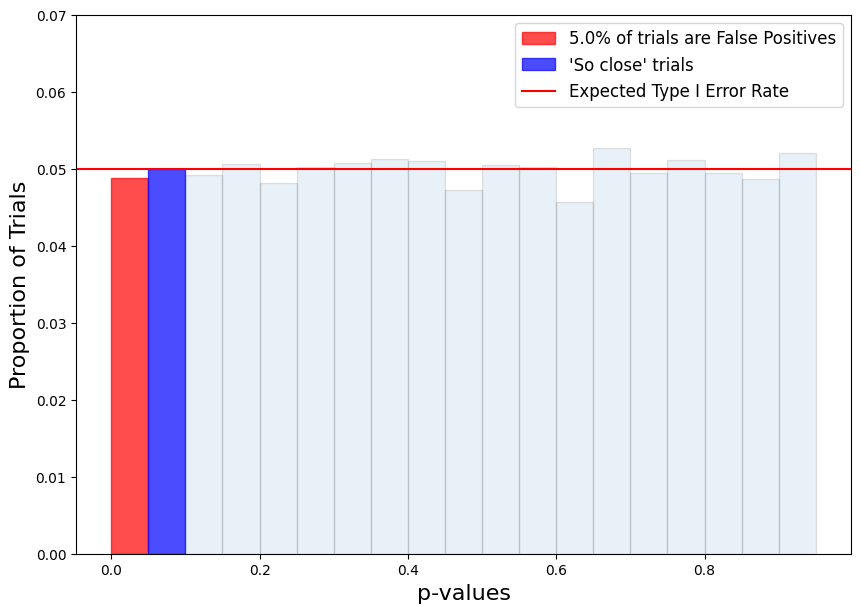

In [6]:
# Plot the pvalues histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

bins = np.arange(0, 1, 0.05)
factor = 1/len(pvals)
cnts, bins = np.histogram(pvals, bins=bins)
cnt, bin_left, patches = ax.hist(bins[:-1],
                                 bins,
                                 weights = factor*cnts,
                                 edgecolor = "black",
                                 alpha = 0.1)

patches[0].set_color("red")
patches[0].set_alpha(0.7)
patches[0].set_label("5.0% of trials are False Positives")

patches[1].set_color("blue")
patches[1].set_alpha(0.7)
patches[1].set_label("'So close' trials")

ax.axhline(0.05,
           color = "red",
           label = "Expected Type I Error Rate")

ax.set_ylim(0.0, 0.07)
ax.set_xlabel("p-values", fontsize=16)
ax.set_ylabel("Proportion of Trials", fontsize=16)

plt.legend(fontsize = 12)
plt.show()

- Figure above highlights in blue the trials where the p-values are **so-close** to exhibiting a significant effect, having magnitudes just above the $\alpha=0.05$ cut off

- If you were an experimenter & happen to get the **so-close** results, you might be tempted to just **extend** your experiment a little longer to see if the **p-values** for those "so-close" trials **decrease** enough to reach statistical significance.

- **Adding new samples** in this way seems totally reasonable because adding more sample will minimize the sample variance thus reduce the false positive rates.

- **But this is $n$ chasing, a common form of p-hacking, don't do it**

In [7]:
# Identify the so-close trials & its p-values
so_close_index = (pvals >= 0.05) & (pvals < 0.1)
so_close_trial_1 = np.array(dataset_trial[0])[so_close_index]
so_close_trial_2 = np.array(dataset_trial[1])[so_close_index]


In [8]:
# additional samples
n_additional = 1

# length of so close trial
n_so_close = len(so_close_trial_1)

# Generate additional samples
additional_samples = np.random.choice(data,
                                      size = (2, n_so_close),
                                      replace = False)

# add to the so close trial
hacked_data_1 = np.column_stack((so_close_trial_1, additional_samples[0]))
hacked_data_2 = np.column_stack((so_close_trial_2, additional_samples[1]))

In [9]:
# Find p_values of each sampled data
pvals_hacked = np.zeros(n_so_close)

for i in range(n_so_close):
    # Calculate pvalue
    pval_i = stats.ttest_ind(hacked_data_1[i],
                             hacked_data_2[i]).pvalue

    # Save p-value to pvals
    pvals_hacked[i] = pval_i


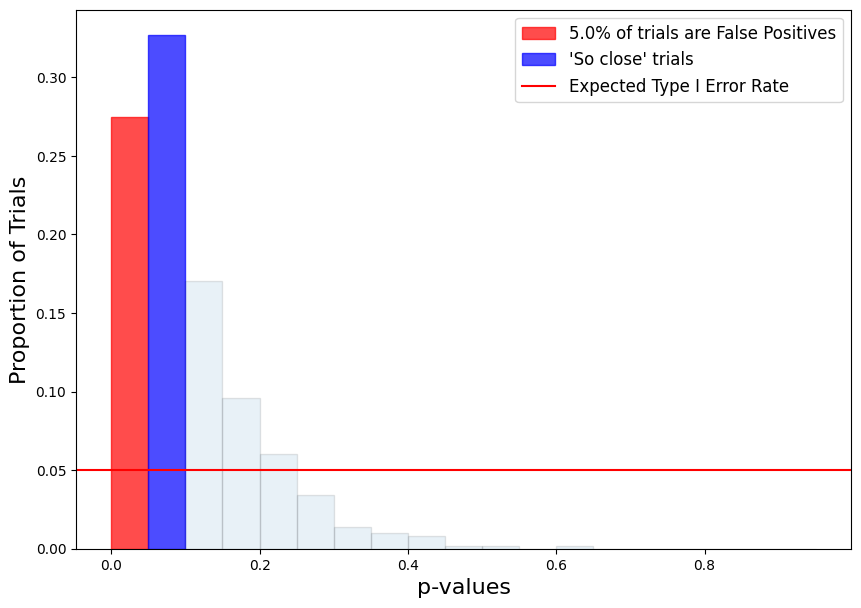

In [10]:
# Plot the pvalues histogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

bins = np.arange(0, 1, 0.05)
factor = 1/len(pvals_hacked)
cnts, bins = np.histogram(pvals_hacked, bins=bins)
cnt, bin_left, patches = ax.hist(bins[:-1],
                                 bins,
                                 weights = factor*cnts,
                                 edgecolor = "black",
                                 alpha = 0.1)

patches[0].set_color("red")
patches[0].set_alpha(0.7)
patches[0].set_label("5.0% of trials are False Positives")

patches[1].set_color("blue")
patches[1].set_alpha(0.7)
patches[1].set_label("'So close' trials")

ax.axhline(0.05,
           color = "red",
           label = "Expected Type I Error Rate")

ax.set_xlabel("p-values", fontsize=16)
ax.set_ylabel("Proportion of Trials", fontsize=16)

plt.legend(fontsize = 12)
plt.show()


- From the above **hacked dataset**, we see that the false positive rate is around 25% (red bar), **five times higher** than the previous **just from adding a single data point to those trials**

## **Simple other $n$ chasing simulation**
---

- What if we **increase** the number of hacked samples ($n_{\text{hacked}}$) and perform repeated experiments.
- Would we also get higher false positive rate?

<font color="red">Let's try it!</font>

In [11]:
def performHackedSimulation(n_additional, data_1, data_2):
    # length of so close trial
    n_so_close = len(so_close_trial_1)

    # Generate additional samples
    additional_samples = np.random.choice(data,
                                          size = (2, n_so_close),
                                          replace = False)

    # add to the so close trial
    hacked_data_1 = np.column_stack((so_close_trial_1, additional_samples[0]))
    hacked_data_2 = np.column_stack((so_close_trial_2, additional_samples[1]))

    # Find p_values of each sampled data
    pvals_hacked = np.zeros(n_so_close)

    for i in range(n_so_close):
        # Calculate pvalue
        pval_i = stats.ttest_ind(hacked_data_1[i],
                                hacked_data_2[i]).pvalue

        # Save p-value to pvals
        pvals_hacked[i] = pval_i

    # Plot the pvalues histogram
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

    bins = np.arange(0, 1, 0.05)
    factor = 1/len(pvals_hacked)
    cnts, bins = np.histogram(pvals_hacked, bins=bins)
    cnt, bin_left, patches = ax.hist(bins[:-1],
                                    bins,
                                    weights = factor*cnts,
                                    edgecolor = "black",
                                    alpha = 0.1)

    patches[0].set_color("red")
    patches[0].set_alpha(0.7)
    patches[0].set_label("5.0% of trials are False Positives")

    patches[1].set_color("blue")
    patches[1].set_alpha(0.7)
    patches[1].set_label("'So close' trials")

    ax.axhline(0.05,
            color = "red",
            label = "Expected Type I Error Rate")

    ax.set_xlabel("p-values", fontsize=16)
    ax.set_ylabel("Proportion of Trials", fontsize=16)

    plt.legend(fontsize = 12)
    plt.show()


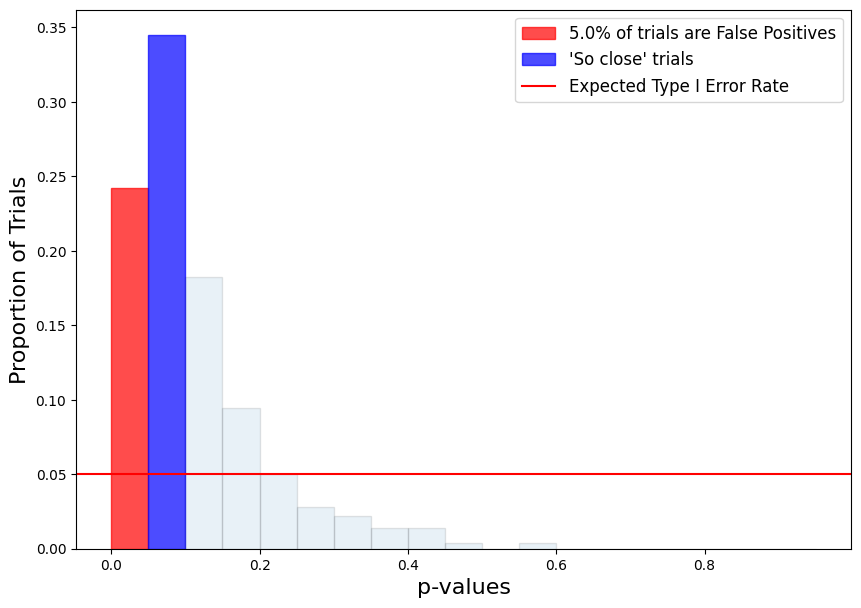

In [12]:
performHackedSimulation(n_additional = 50,
                        data_1 = so_close_trial_1,
                        data_2 = so_close_trial_2)

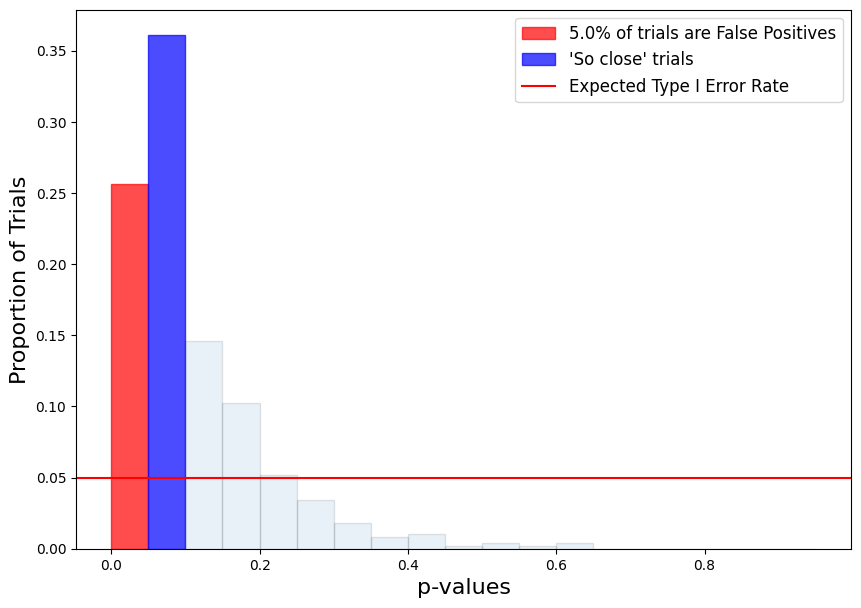

In [13]:
performHackedSimulation(n_additional = 1000,
                        data_1 = so_close_trial_1,
                        data_2 = so_close_trial_2)

- The results are similar, you will get higher false positive rates.

**Remember**
- Suppose you've designed an experiment, say with $n = 50$
- After getting $n=50$, your experiment did not reach significance.
- Then decide to keep running the experiment after looking at the final results.
- If you've ever said something like **oh, let's just run it a little longer**, then you're probably p-hacking.

# <font color='blue'>3. Power Analysis</font>
---


- One way to avoid the p-hacking is by deciding the optimum sample size with **Power Analysis**
- Power is the probability to reject $H_{0}$ given $H_{0}$ is false.

$$
\text{power} = 1-\beta = P(\text{reject } H_{0} \ | \ H_{0} \text{ is false})
$$

- Generally, we want to get a big power to ensure we reject the false ones.
- Power is dependent to
  - Effect size
  - Data variance
  - Sample size ($n$)

## **Effect Size vs Power**
---

- Effect size shows the difference between two groups, i.e. $(\mu_{A} - \mu_{B})/ \sigma $
- Let's simulate it

In [14]:
def simulatePower(prop_1, prop_2, N=10000, n_repeat=1000):
    # Random seed
    np.random.seed(1234)

    # Extract data
    mu_1 = prop_1["mean"]
    std_1 = prop_1["std_dev"]
    n_1 = prop_1["n_sample"]

    mu_2 = prop_2["mean"]
    std_2 = prop_2["std_dev"]
    n_2 = prop_2["n_sample"]

    # 1. GENERATE POPULATION DATA (from normal distribution)
    data_1 = np.random.normal(mu_1, std_1, N)
    data_2 = np.random.normal(mu_2, std_2, N)

    # 2. SIMULATE THE SAMPLING PROCESS
    sample_1_mean = []
    sample_2_mean = []

    for i in range(n_repeat):
        # Generate data
        sample_1 = np.random.choice(data_1, size=(1, n_1), replace=False)
        sample_2 = np.random.choice(data_2, size=(1, n_2), replace=False)

        # Generate mean
        mean_1 = sample_1.mean()
        mean_2 = sample_2.mean()

        # Append mean to the list
        sample_1_mean.append(mean_1)
        sample_2_mean.append(mean_2)

    # 3. VISUALIZE THE MEAN DISTRIBUTION
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

    ax.hist(sample_1_mean, alpha = 0.5, bins = 10,
            label = r"Group 1 - $H_0$")
    ax.hist(sample_2_mean, alpha = 0.5, bins = 10,
            label = r"Group 2 - $H_1$")

    ax.set_ylabel("Frequency")
    plt.legend()
    plt.show()


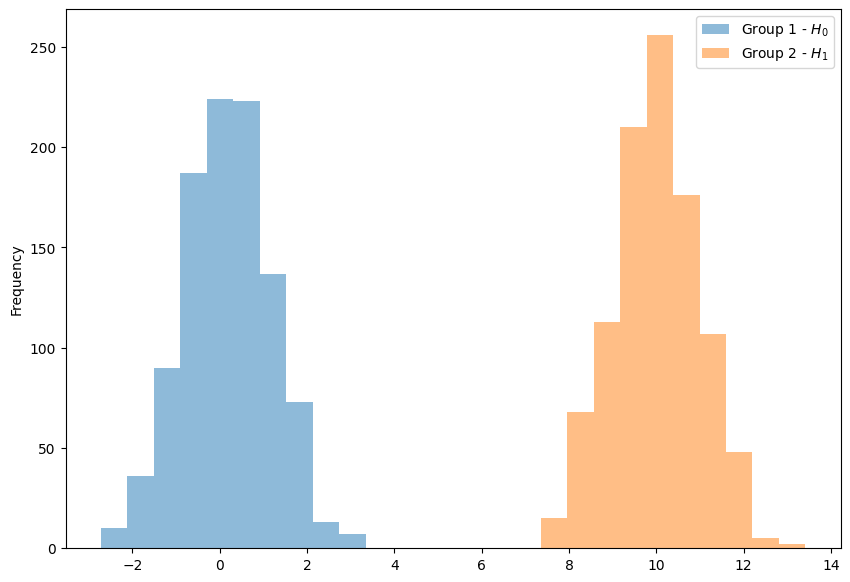

In [15]:
# Define effect size
effect_size = 10

# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 10,
          "n_sample": 100}

prop_2 = {"mean": effect_size,
          "std_dev": 10,
          "n_sample": 100}

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

- Based on the above figures, we can see that there is no overlap between the two groups.
- Thus, if you reject the $H_{0}$, the probability of reject $H_{0}$ given $H_{0}$ is false is 100%
- **What happen if we decrease the effect size**? say to 2.0

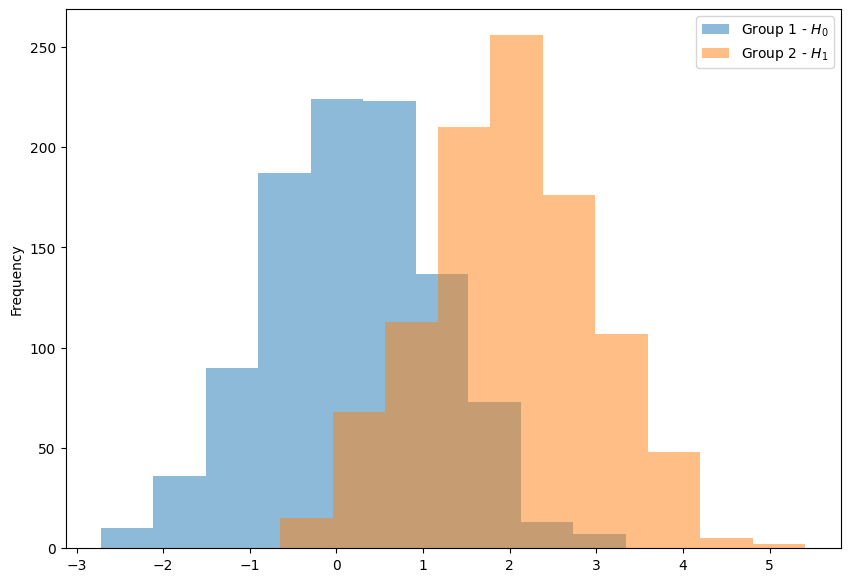

In [16]:
# Define effect size
effect_size = 2

# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 10,
          "n_sample": 100}

prop_2 = {"mean": effect_size,
          "std_dev": 10,
          "n_sample": 100}

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

- When you **decrease the effect size**, the groups would be **overlaped** hence **decreasing the power** (the probability of rejceting $H_{0}$ given $H_{0}$ is false)
- So be **careful** when you do an experiment with small effect size.

## **Variance vs Power**
---

- Let's simulate the variance vs power on the same effect size

- First simulation:
  - Effect size = 10
  - Variance = 100 --> standard deviation = 10

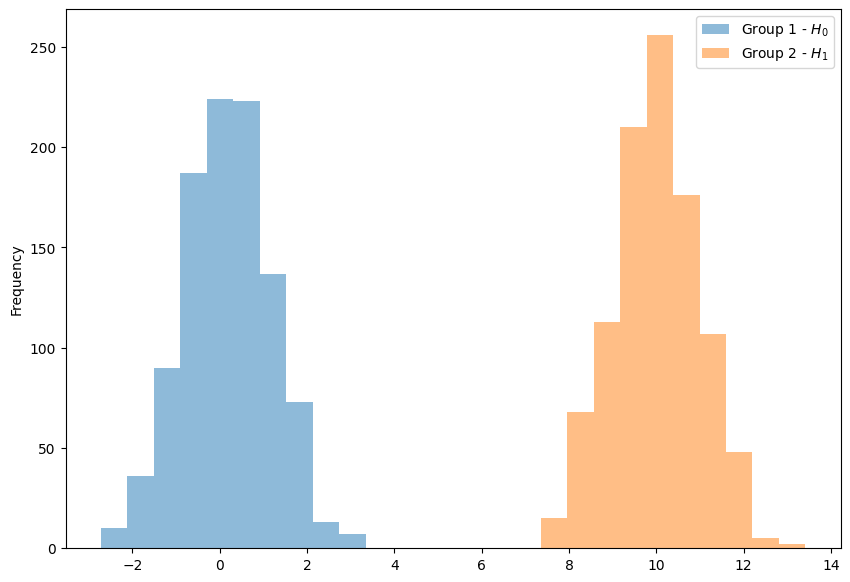

In [17]:
# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 10,
          "n_sample": 100}

prop_2 = {"mean": 10,
          "std_dev": 10,
          "n_sample": 100}

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

- Small groups variance makes high power. (no overlapped data)
- What if we **enlarge the variance**?

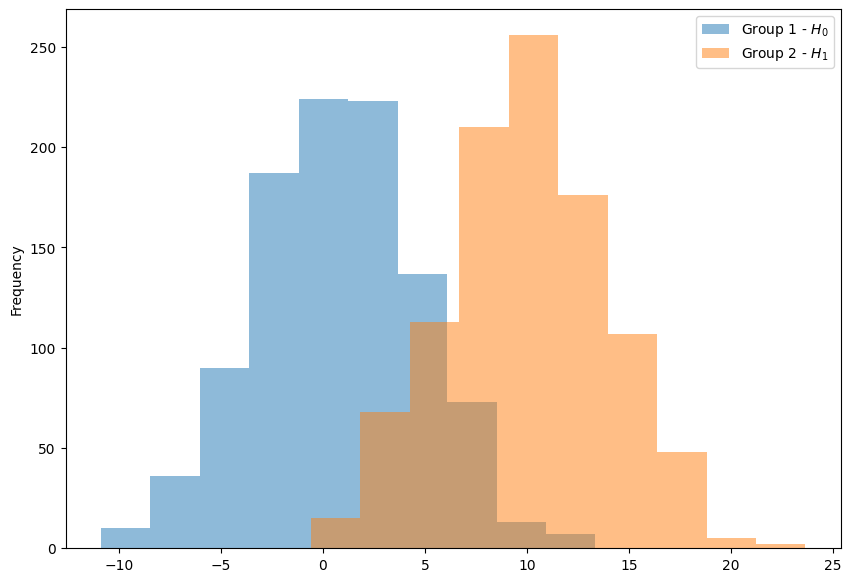

In [18]:
# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 40,
          "n_sample": 100}

prop_2 = {"mean": 10,
          "std_dev": 40,
          "n_sample": 100}

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

- **Enlarging** both of groups variance will create overlap of the two groups, hence **reducing** the power.

- What if we have **different group variance?**

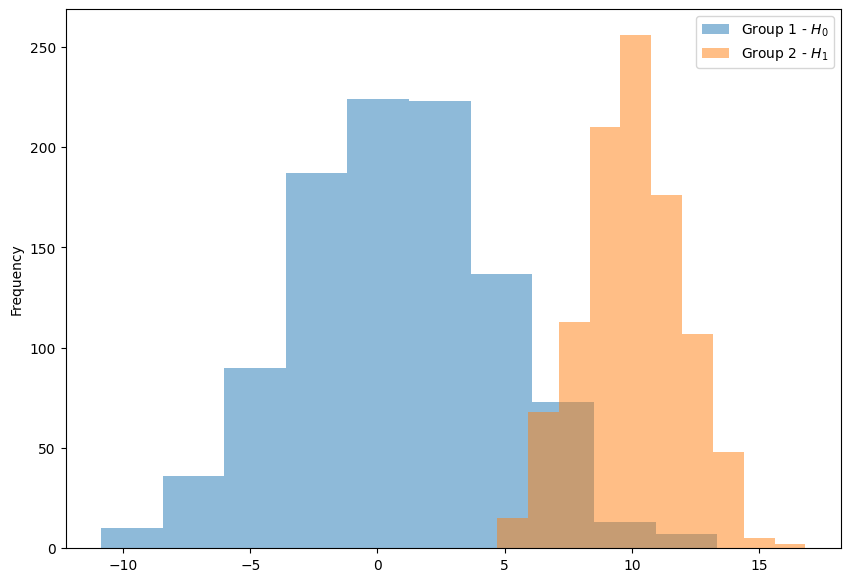

In [19]:
# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 40,        # variance 1
          "n_sample": 100}

prop_2 = {"mean": 10,
          "std_dev": 20,        # variance 2
          "n_sample": 100}

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

## **Sample Size vs Power**
---

- Now lets simulate the effect of sample size

- First, we use the same sample size with some effect size on similar group variance.

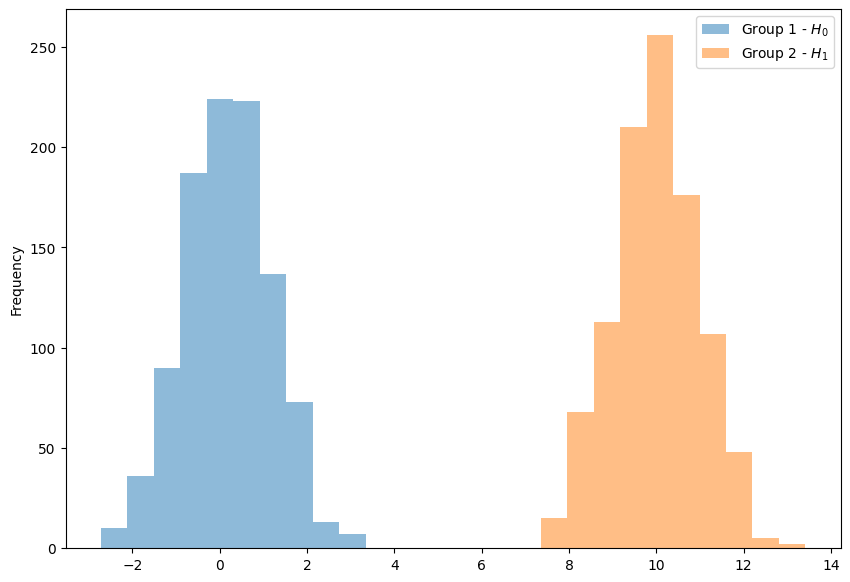

In [20]:
# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 10,
          "n_sample": 100}

prop_2 = {"mean": 10,
          "std_dev": 10,
          "n_sample": 100}

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

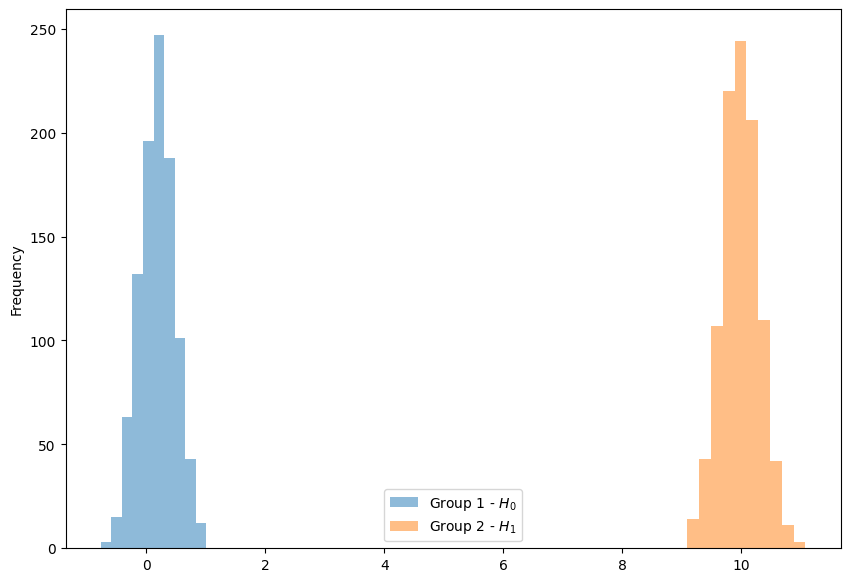

In [21]:
# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 10,
          "n_sample": 1000}     # From 100 to 1000

prop_2 = {"mean": 10,
          "std_dev": 10,
          "n_sample": 1000}     # From 100 to 1000

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

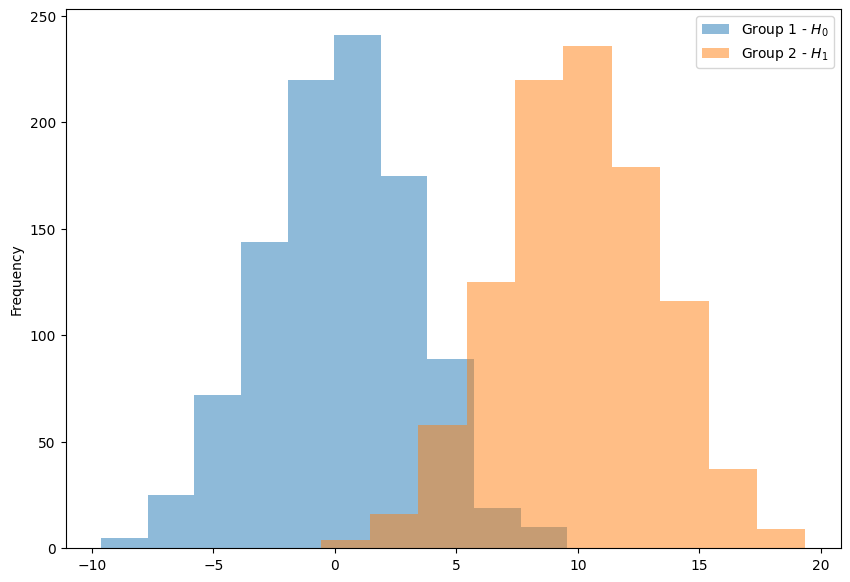

In [22]:
# Define property each group
prop_1 = {"mean": 0,
          "std_dev": 10,
          "n_sample": 10}     # From 100 to 10

prop_2 = {"mean": 10,
          "std_dev": 10,
          "n_sample": 10}     # From 100 to 10

# Simulate
simulatePower(prop_1 = prop_1,
              prop_2 = prop_2)

- As you can see, there is an overlap between two groups
- Hence **decrease** the power.
- In conclusion
  - Increasing the sample size will **decreasing** the variance, hence **increasing** the power
  - While, decreasing the sample size will **increasing** the variance, hence **decreasing** the power

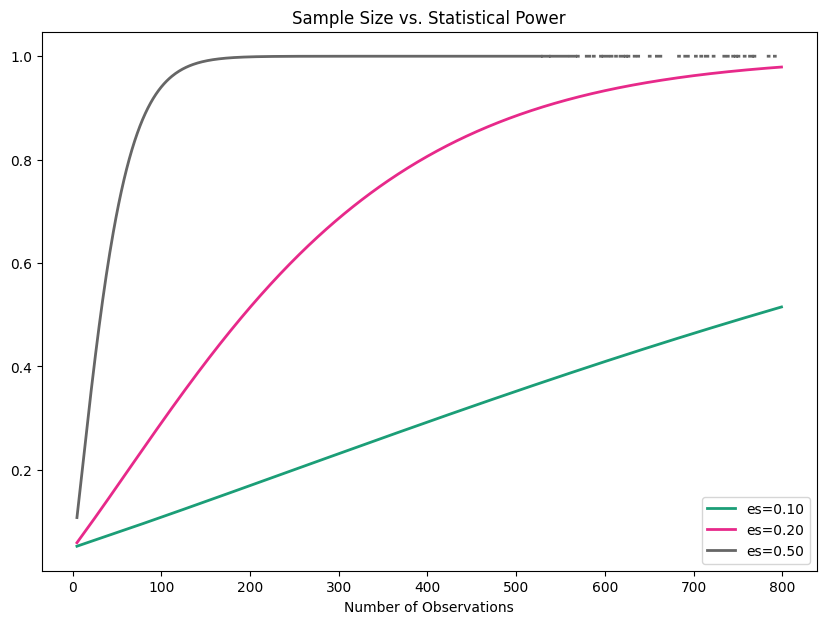

In [23]:
# Import library
from statsmodels.stats.power import TTestIndPower

# Initiate the power analysis
power_analysis = TTestIndPower()

# Visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

power_analysis.plot_power(dep_var = 'nobs',
                          nobs = np.arange(5, 800),
                          effect_size = [0.1, 0.2, 0.5],
                          alpha = 0.05,
                          title = 'Sample Size vs. Statistical Power',
                          ax = ax)
plt.show()

# <font color='blue'>4. Calculating Sample Size</font>
---


**Case Descriptions**
- Marketing companies want to run successful campaigns.
- They have a new initiative in campaigns, let say campaigns B.
- Before implementing campaign B, they conduct an experiment to compare existing campaign (campaign A) and new campaign (campaigns B).
- With the new campaigns, it is expected that the conversion rate will increase by 3%.
- It is known that 1 month ago, the standar deviation was 4%.

**Questions**
1. With a significance level of 5% and a power of 80%, How many minimum sample size are needed?
2. If in one week, you can collect 20 samples for each group, determine the power of your experiments.

---
## 1. How many minimum sample size are needed when $\alpha=5 \%$ and power 80%?

- Remember, we can use the given formula to calculate the minimum number of sample size needed.

$$
n = \cfrac{2 \sigma^2 (z_{1-\alpha/2}+z_{1-\beta})^2}{\delta^2}
$$

- Thus, if we have the $z$ value, we can determine the number of sample.
- Let's find it.

In [24]:
# Given
delta = 0.03        # absolute increase of two groups means
alpha = 0.05        # significance level
power = 0.8         # power
std_dev = 0.04      # variance of population (assumed / approximated)


In [25]:
# calculate beta
beta = 1 - power
beta

0.19999999999999996

In [26]:
# calculate the z value
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(1 - beta)

z_alpha, z_beta

(np.float64(1.959963984540054), np.float64(0.8416212335729143))

In [27]:
# then calculate the number of sample size
n = 2 * (std_dev**2) * ((z_alpha+z_beta)**2) / (delta**2)

print(f"Number of sample size needed    : {n:.2f}")

Number of sample size needed    : 27.91


**In conclusion**
- We need 28 samples in one group
- and 56 sample for two groups.

---
## 2. Determine the power of your experiment if you can only collect 20 samples for each groups in one week.

- Suppose you run the experiment in one week
- and can collect 20 samples for each group
- Determine your power of experiments.

---
**First way**
- We can reform the sample size formula. from

$$
n = \cfrac{2 \sigma^2 (z_{1-\alpha/2}+z_{1-\beta})^2}{\delta^2}
$$

- to
$$
z_{1-\beta} = \sqrt{\cfrac{n \delta^{2}}{2 \sigma^{2}}} - z_{1-\alpha/2}
$$

In [28]:
# Given
n = 20          # assume that is the minimum sample size we use
delta = 0.03
std_dev = 0.04
alpha = 0.05


In [29]:
# Calculate the z_alpha
z_alpha = stats.norm.ppf(1 - alpha/2)
z_alpha

np.float64(1.959963984540054)

In [30]:
# Calculate the z_beta
z_beta = np.sqrt((n * (delta**2))/(2 * std_dev**2)) - z_alpha
z_beta

np.float64(0.4117442605862305)

- From the given $z_{1-\beta}$ find $1-\beta$ or power

In [31]:
# using library stats.norm.sf(z_value)
beta = stats.norm.sf(z_beta)
print(f"beta            : {beta:.2f}")

# find power
power = 1 - beta
print(f"Power in 1 week : {power*100:.2f} %")

beta            : 0.34
Power in 1 week : 65.97 %


---
**Second way**
- We can calculate it by using `power.TTestIndPower.power()`

In [32]:
# Given
n = 20          # assume that is the minimum sample size we use
delta = 0.03
std_dev = 0.04
alpha = 0.05


In [33]:
# parameters for power analysis
effect_size = delta/std_dev

# Initiate the power analysis
power_analysis = TTestIndPower()

# Calculate power
power = power_analysis.power(effect_size = effect_size,
                             alpha = alpha,
                             nobs1 = n,
                             ratio = 1)

# Print results
print(f"Power in 1 week : {power*100:.2f} %")

Power in 1 week : 63.74 %


- Similar right?
- **What will you do next** knowing your power only 65%?
- Will you do a p-hacking?

---
## Additional case in calculating sample size

**Case Descriptions**
- Marketing companies want to run successful campaigns.
- They have a new initiative in campaigns, let say campaigns B.
- Before implementing campaign B, they conduct an experiment to compare existing campaign (campaign A) and new campaign (campaigns B).
- With the new campaigns, it is expected that the conversion rate will increase by 3%.
- It is known that the **baseline conversion rate** is 2%

**Questions**

- With a significance level of 5% and a power of 80%, How many minimum sample size are needed?

- In that case, we don't know the standard deviation of the conversion rate.
- However, we can calculate the standard deviation with the information of current baseline conversion rate.
- The conversion event is a Bernoulli trial, with $\hat{p}=0.02$
- We can calculate the standard deviation by using the following formula with approach of Bernoulli distribution:

$$\sigma=\sqrt{\hat{p}(1-\hat{p})}$$


In [34]:
# calculate standar deviation

#given
p=0.02

std_dev = np.sqrt(p*(1-p))
std_dev

np.float64(0.13999999999999999)

In [35]:
# Given
delta = 0.03        # absolute increase of two groups means
alpha = 0.05        # significance level
power = 0.8         # power


In [36]:
# calculate beta
beta = 1 - power
beta

0.19999999999999996

In [37]:
# calculate the z value
z_alpha = stats.norm.ppf(1 - alpha/2)
z_beta = stats.norm.ppf(1 - beta)

z_alpha, z_beta

(np.float64(1.959963984540054), np.float64(0.8416212335729143))

Because standar deviation is higher, so the sample size is higher.

**In conclusion**
- We need 342 samples in one group
- and 684 sample for two groups.